[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nepslor/B5203E-TSAF/blob/main/W4/Embeddings_and_takens_theorem_solutions.ipynb)

# Embeddings as forecasting features - Takens' Theorem
Let's consider a (possibly nonlinear) dynamical, $n$-state system, which we write of the form:

\begin{equation}
s_t=g(s_{t−1}) \qquad (1)
\end{equation}

For example, we can use the Lorenz system:
The Lorenz system is an $n=3$ dynamical system defined as:
\begin{cases}
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x (\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z,
\end{aligned}
\end{cases}
where $\sigma$, $\rho$, and $\beta$ are parameters.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the Lorenz system of differential equations
def lorenz(t, y, sigma, rho, beta):
    dydt = [sigma * (y[1] - y[0]),
            y[0] * (rho - y[2]) - y[1],
            y[0] * y[1] - beta * y[2]]
    return dydt

# Set the parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Set the initial conditions
initial_conditions = [1.0, 0.0, 20.0]

# Set the time span for integration
t_span = (0, 120)
t_eval = np.linspace(t_span[0], t_span[1], 12000)

# Solve the system of differential equations
sol = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), t_eval=t_eval)


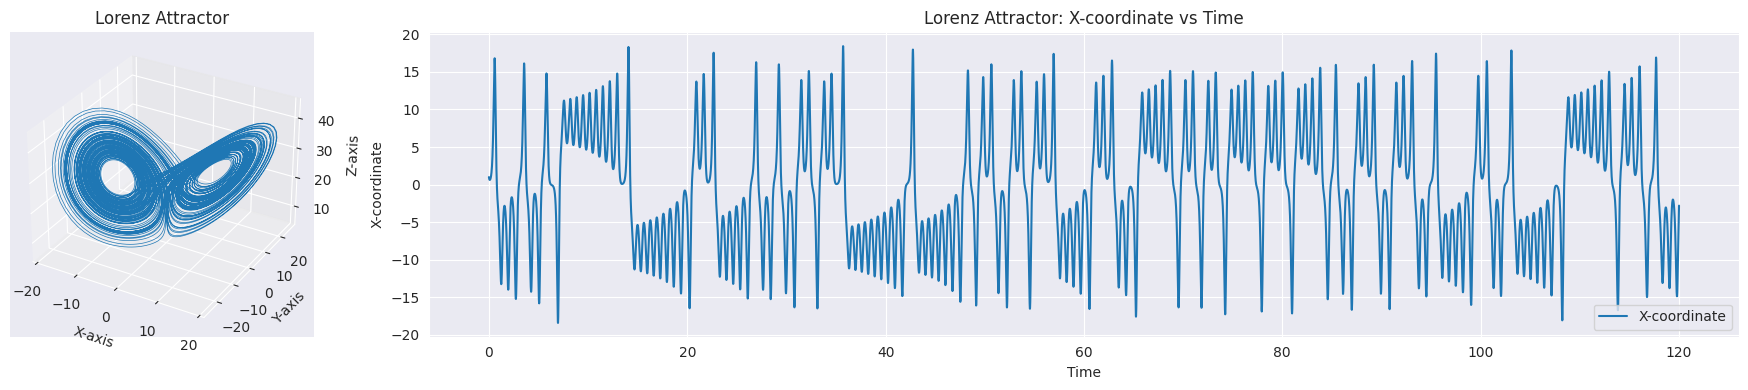

In [2]:
# Plot the Lorenz attractor
fig = plt.figure(figsize=(18, 4), layout='tight')
ax = fig.add_subplot(141, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.5)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Lorenz Attractor')

# plot the first coordinate only
ax = fig.add_subplot(1, 4, (2, 4))
ax.plot(sol.t, sol.y[0], label='X-coordinate')
ax.set_xlabel('Time')
ax.set_ylabel('X-coordinate')
ax.set_title('Lorenz Attractor: X-coordinate vs Time')
ax.legend()
plt.show()

## Takens' theorem
Since (1) is a deterministic system, the initial condition $s_{t0}$ determines the entire evolution of the system and, consequently, the entire realization of the observable. This means that the entire sequence depends on the initial condition, in the sense that different initial conditions will lead to different state sequences.

We now wonder whether the opposite is true or not, i.e., if one can reconstruct the state of the system by observing a series of one-dimensional measures.
Takens’ theorem deals with this question.
$$e_t(m ,\tau) = [x(t), x(t-\tau),        \cdots  x(t-(m-1)\tau)]$$

Takens has shown that embeddings with $m>2n$ will be faithful generically so that there is a smooth map $f:\mathbb{R}^m→ \mathbb{R}$ such that
$$x_{t+1} = f(e_t(m, \tau))$$

We can define a dataset of delayed vectors
$$E(m,\tau) =
\begin{bmatrix}
x(T)         & x(T-\tau)       & \cdots & x(T-(m-1)\tau) \\
x(T-1)       & x(T-\tau-1)     & \cdots & x(T-(m-1)\tau-1) \\
x(T-2)       & x(T-\tau-2)     & \cdots & x(T-(m-1)\tau-2) \\
\vdots      & \vdots      & \ddots & \vdots \\
x((m-1)\tau) & x((m-1)\tau-\tau) & \cdots & x(0)
\end{bmatrix} =
\begin{bmatrix}
e_T(m, \tau) \\
e_{T-1}(m, \tau)\\
\vdots\\
e_{m\tau}(m, \tau)
\end{bmatrix}
$$
and train a regressor to predict
$$\Vert f(E(m,\tau)) -x \Vert_2$$

In [3]:
# Extract the x-coordinate
x = sol.y[0]

#create train and test, discarding some initial points
n_tr = 10000
x_train, x_test = x[500:500+n_tr], x[n_tr+500:]


We now create the function producing the embedding matrix $E(m,\tau)$

In [4]:
# Create a delay embedding
def delay_embedding(data, d, tau):
    N = len(data)
    indices = np.arange(d) * tau + np.arange(N - (d - 1) * tau)[:, None]
    embedded_data = data[indices]
    return embedded_data

In [5]:
# Here's an example
arr = np.array([1,2,3,4,5,6,7,8,9])
emb = delay_embedding(arr,4,2)
emb

array([[1, 3, 5, 7],
       [2, 4, 6, 8],
       [3, 5, 7, 9]])

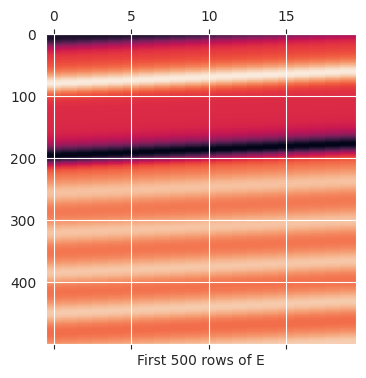

In [6]:
# Set parameters for delay embedding
d = 20  # Number of delays
tau = 1  # Time delay

# Create delay embedding
embedded_data = delay_embedding(x_train, d, tau)
plt.matshow(embedded_data[:500, :],aspect=0.04);
plt.xlabel('First {} rows of E'.format(500));


We now try to approximate $f$ using a linear function.

### ❓ Use Ridge regression to learn a linear model predicting one step ahead.


In [7]:
from sklearn import linear_model

X = embedded_data[:-1,:]
Y = embedded_data[1:,-1]

linear_predictor = linear_model.Ridge(alpha = 1e-5)
linear_predictor.fit(X,Y);


[]

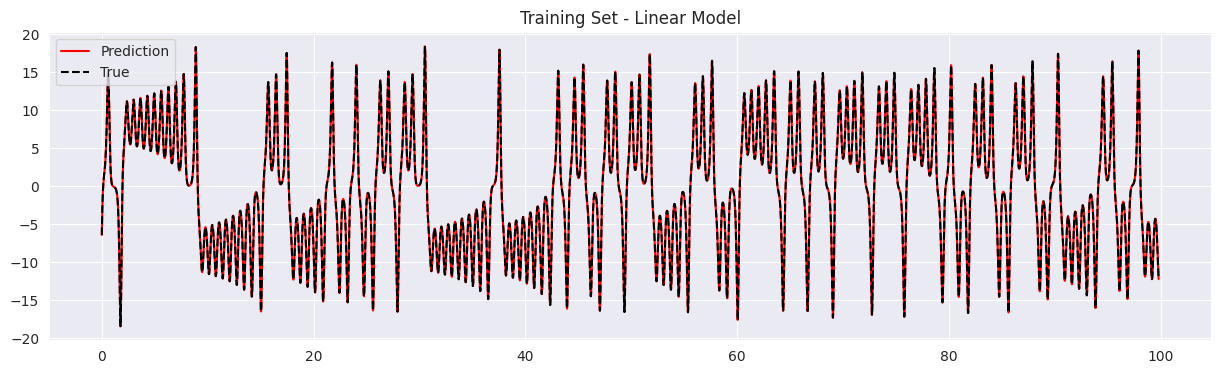

In [8]:
train_reconstructed = linear_predictor.predict(X)
fig = plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(Y))*1e-2,train_reconstructed,"r", label = "Prediction")
plt.plot(np.arange(len(Y))*1e-2,Y, "k--", label = "True")
plt.title("Training Set - Linear Model")
plt.legend()
plt.savefig("Train_linear")
plt.plot()

We did quite a good job at predicting one step ahead, but to really assess the goodness of the model we should try to forecast more than one step ahead. Let's implement a recursive strategy:

<img src="https://github.com/nepslor/B5203E-TSAF/raw/95ab6491476169ca761b47d1bee8735b12346694/pics/recursive_forecast.png" width="600">

### ❓ Implement the recursive strategy and plot the results

In [9]:
x_start=X[-1,:]
x_start = x_start[ np.newaxis,:]
L_seq = 900
x = x_start

# recursive strategy:
preds = []
for _ in range(L_seq):
    pred = linear_predictor.predict(x)
    preds.append(pred)
    x = np.concatenate((x[:,1:],pred[np.newaxis,:]), axis=1)



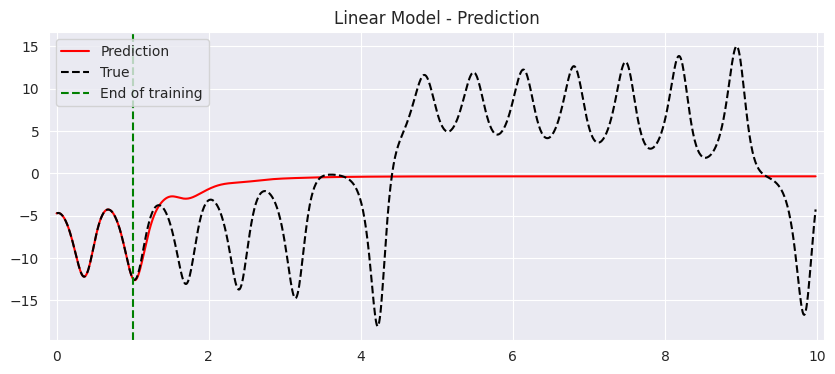

In [10]:
preds = np.array(preds)
final_part = train_reconstructed[-100:].reshape(-1,1)
continuation = np.concatenate([final_part,preds[1:]])

fig = plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(continuation))*1e-2, continuation, 'r', label = "Prediction")
plt.plot(np.arange(len(continuation))*1e-2,np.concatenate([x_train[-100:],x_test[:L_seq-1]]), 'k--', label = "True")

plt.xlim([-0.1, (len(continuation)*1e-2) + 0.1])
# Plot a horizontal line to separate train and prediction
plt.axvline(x=len(final_part)*1e-2, color='g', linestyle='--', label='End of training')
plt.title("Linear Model - Prediction")
plt.legend()
plt.savefig("Test_linear")
plt.show()




We didn't go very far in predicting the system's trajectory. We can increase the expressivity of the model by trying to use a feed-forward neural net.

Epoch 0, Loss: 1.4226033687591553
Epoch 10, Loss: 0.018350103870034218
Epoch 20, Loss: 0.0007237719255499542
Epoch 30, Loss: 0.0010873695136979222
Epoch 40, Loss: 0.0005264171632006764
Epoch 50, Loss: 0.0007217177771963179
Epoch 60, Loss: 0.002603770699352026
Epoch 70, Loss: 0.0004891969729214907
Epoch 80, Loss: 0.00020293417037464678
Epoch 90, Loss: 0.0004917805199511349


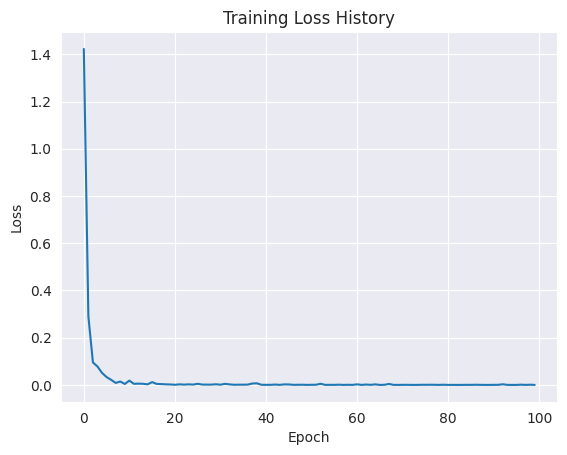

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
learning_rate = 1e-4
num_epochs = 100
batch_size = 32


# Create the neural network model
model = NeuralNetwork(input_dim, hidden_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a DataLoader for batching
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Lists to store loss history
loss_history = []

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Append the current loss to the loss history list
    loss_history.append(loss.item())

# Use the trained model for prediction
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.savefig('Loss')
plt.show()


[]

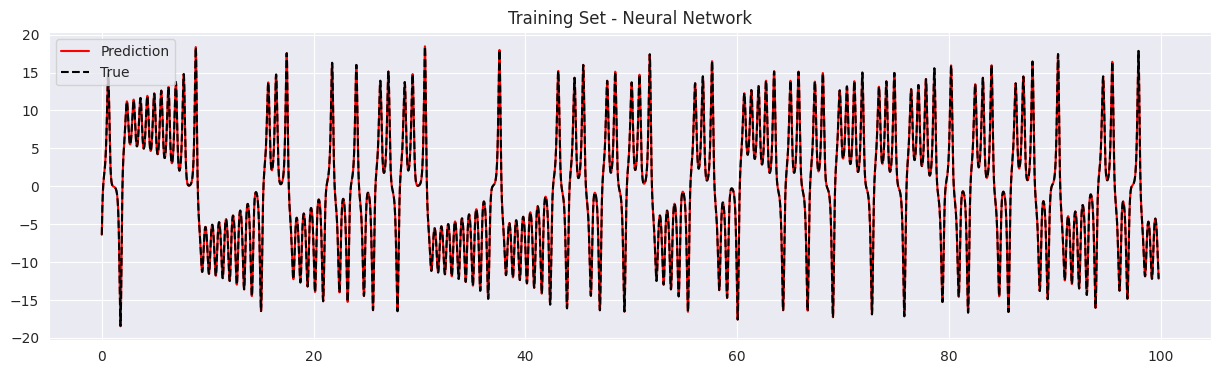

In [13]:
fig = plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(Y))*1e-2,predictions,'r', label = "Prediction")
plt.plot(np.arange(len(Y))*1e-2, Y, 'k--', label = "True")
plt.title("Training Set - Neural Network")
plt.legend()
plt.savefig("Train_nn")
plt.plot()


In [14]:
x_start=X[-1,:]
x_start = x_start[ np.newaxis,:]
x_start=torch.tensor(x_start, dtype=torch.float32)
L_seq = 1500
x = x_start

nn_preds = []
for _ in range(L_seq):
    pred = model(x)
    nn_preds.append(pred.detach().numpy()[0])
    x = torch.concatenate((x[:,1:],pred), axis=1)



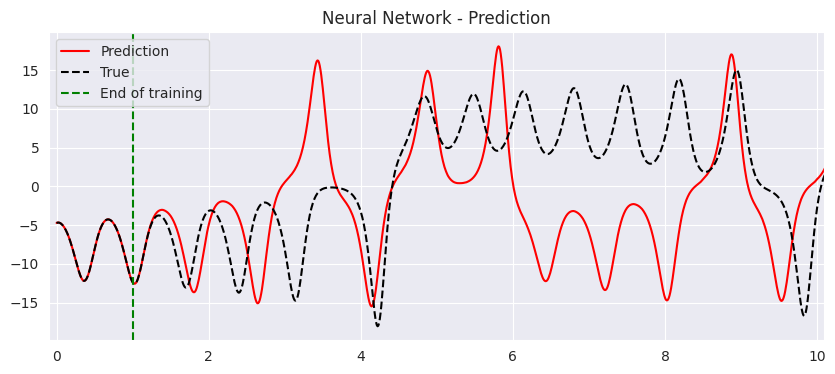

In [15]:
nn_preds = np.array(nn_preds)
final_part = train_reconstructed[-100:].reshape(-1,1)
continuation_nonlin = np.concatenate([final_part,nn_preds[1:]])


# FIGURE
fig = plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(continuation_nonlin))*1e-2, continuation_nonlin, 'r', label = "Prediction")
plt.plot(np.arange(len(continuation_nonlin))*1e-2,np.concatenate([x_train[-100:],x_test[:L_seq-1]]), 'k--', label = "True")
plt.xlim([-0.1, (len(continuation)*1e-2) + 0.1])
# Plot a horizontal line to separate train and prediction
plt.axvline(x=len(final_part)*1e-2, color='g', linestyle='--', label='End of training')

plt.title("Neural Network - Prediction")
plt.legend()
plt.savefig("Test_nn")
plt.show()

